# EDA - 1.0

## Imports

In [2]:
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import datetime as dt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

from Utils import *

In [9]:
def CPrint(text: str, colour=Fore.BLUE, style=Style.BRIGHT):
    print(style+colour+text+Style.RESET_ALL)

## Data Loading

In [4]:
data_folder = '../data/raw/'
series = "train_series.parquet"
events = "train_events.csv"
id_map = "train_id_map.parquet"

# train_series = pd.read_parquet(data_folder+series)
train_events = pd.read_csv(data_folder+events)
train_id_map = pd.read_parquet(data_folder+id_map)

### Create Train_ID_map

In [5]:
unique_series_ids = np.unique(train_series.series_id)

train_id_map = pd.DataFrame({
    "series_id": unique_series_ids,
    "id_map": np.arange(len(unique_series_ids), dtype=np.uint16)
})

train_id_map.to_parquet("../data/train_id_map.parquet", index=False)

In [6]:
folder = '..\\data\\'
id_map = "train_id_map.parquet"

train_id_map = pd.read_parquet(folder+id_map)

### Transforming dataset

In [9]:
train_series = transform_and_rename_dataframe(train_series, train_id_map, 'series_id', ['series_id'], {'id_map': 'series_id'})
train_events = transform_and_rename_dataframe(train_events, train_id_map, 'series_id', ['series_id'], {'id_map': 'series_id'})
#train_series.timestamp = pd.to_datetime(train_series.timestamp) # waited for 40 minutes but it was still running

In [23]:
series_chunk = train_series[:100000].copy()

In [19]:
train_events = clean_df(train_events)
# series_chunk = clean_df(series_chunk)

## Data Processing

### Duplicate/Null Values

In [46]:
for col in train_events.columns:
    pct_miss = 100*(train_events[col].isnull().sum()/train_events[col].shape[0])
    txt = f"Column: {col}\t Percent of NaN value: {pct_miss}"
    CPrint(f"\n {txt}")


 Column: series_id	 Percent of NaN value: 0.0

 Column: night	 Percent of NaN value: 0.0

 Column: event	 Percent of NaN value: 0.0

 Column: step	 Percent of NaN value: 33.93300248138958

 Column: timestamp	 Percent of NaN value: 33.93300248138958


<Axes: >

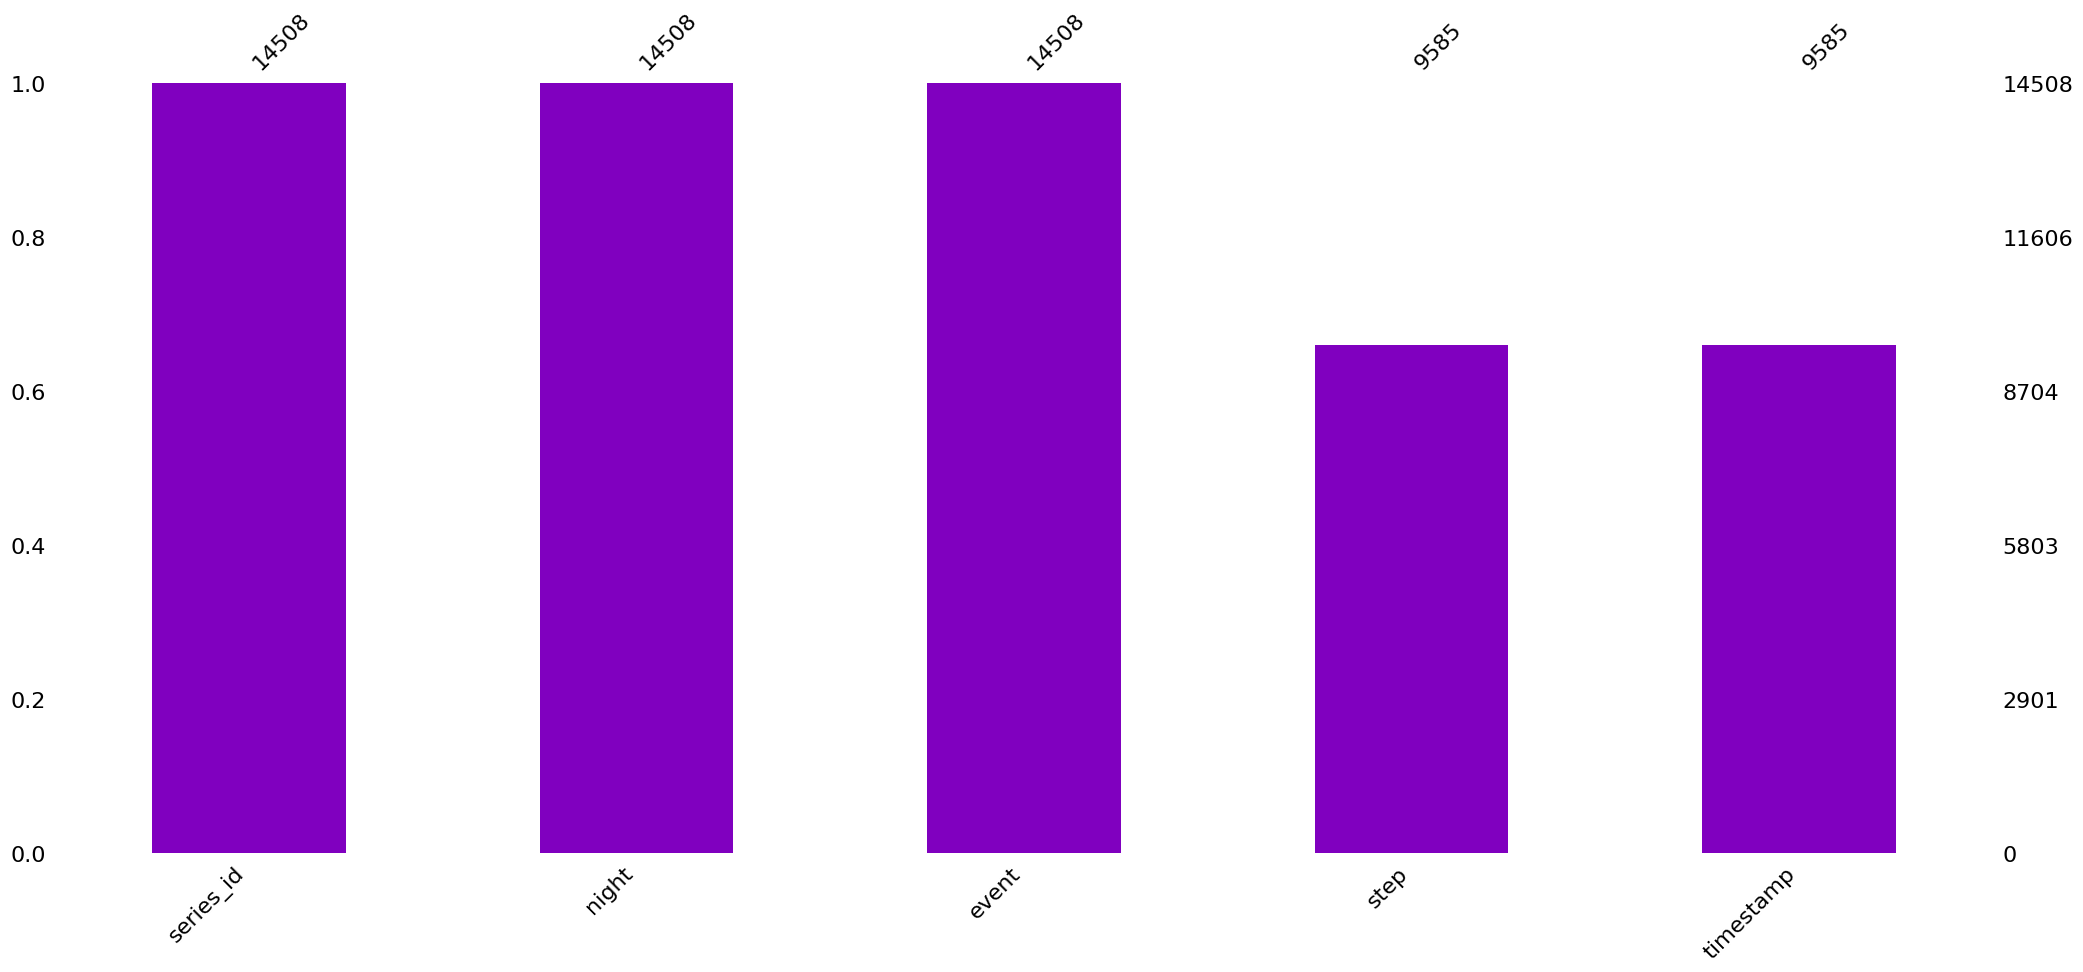

In [12]:
msno.bar(train_events, color=(0.5,0.0,0.75))

<Axes: >

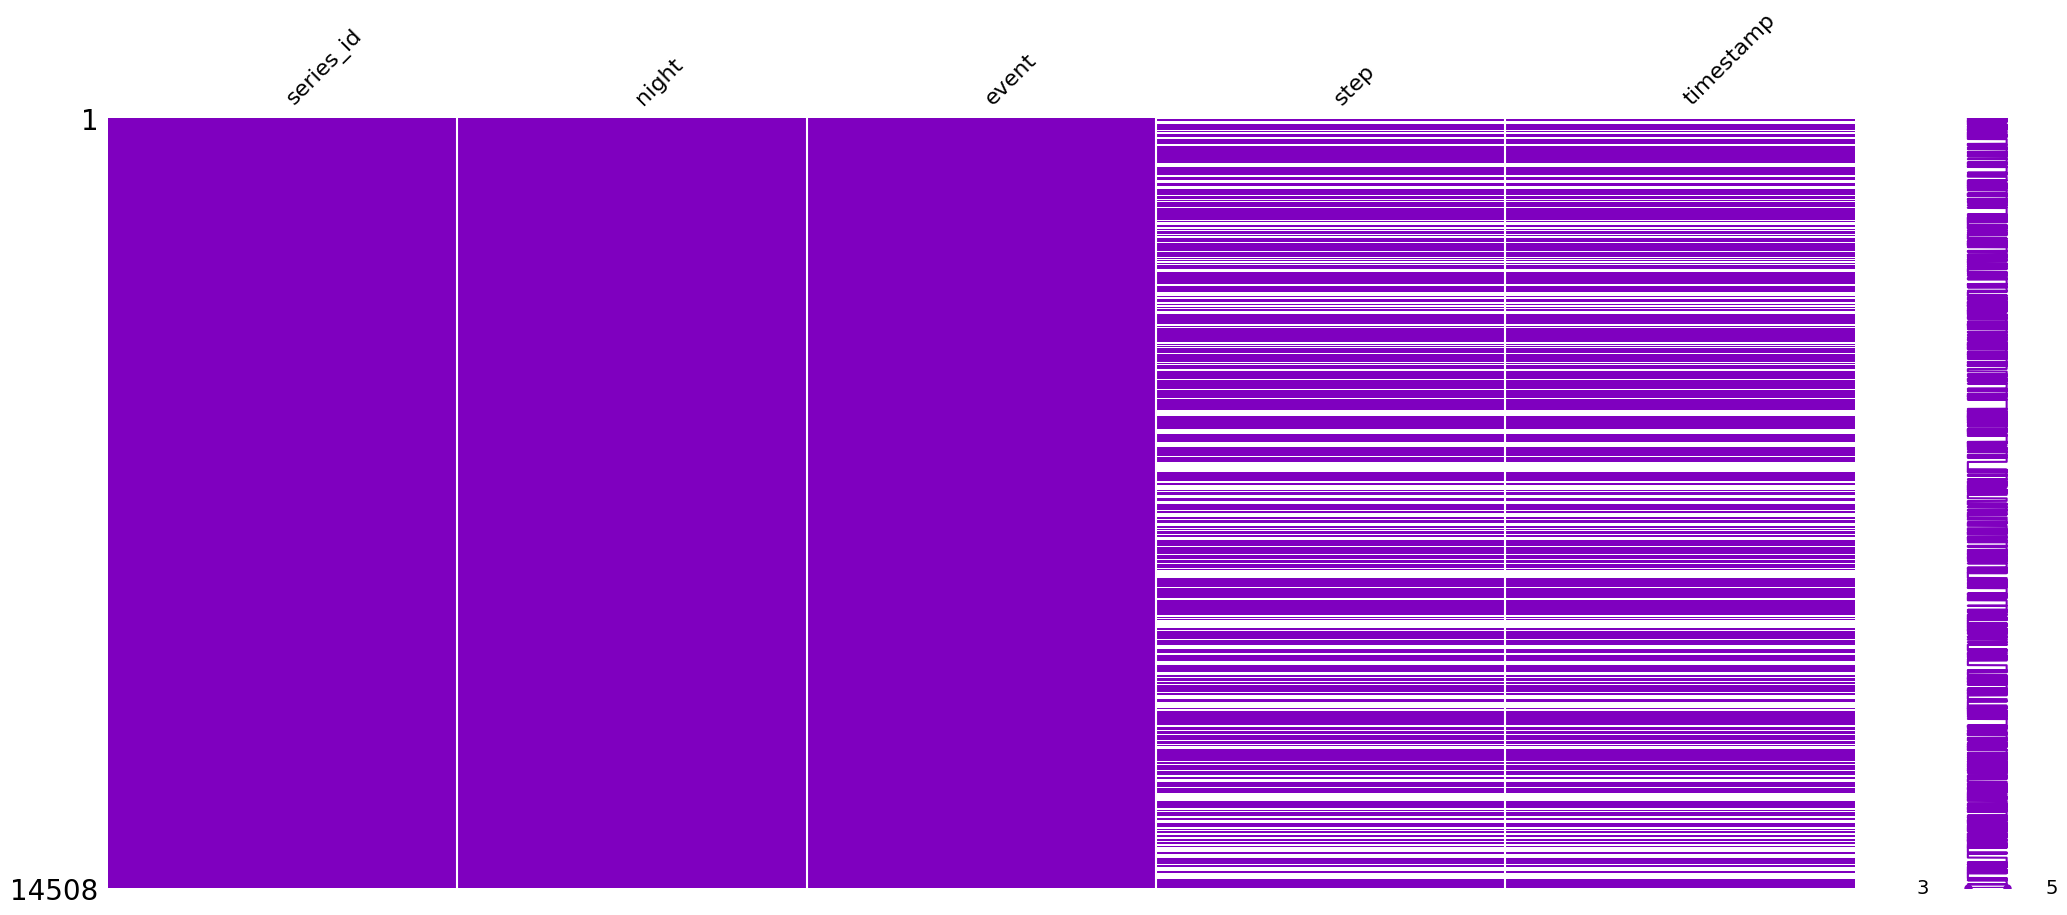

In [13]:
msno.matrix(train_events, color=(0.5,0.0,0.75))

As we can see from the above plots:

- **step**, **timestamp**, **data**, **time**, and **hour** all have 33.9% NaN values.

Due to the nature of the data, it is impossible to interpolate these values, arguably you could impute them after merging on train_series. However, this introduces noise and innacuracies into your dataset.

### Series_id coverage

In [43]:
train_events.describe(include='all')

,series_id,night,event,step,timestamp
count,14508,14508.000000,14508,9585.000000,9585
unique,277,NaN,2,NaN,9360
top,78569a801a38,NaN,onset,NaN,2017-11-27T21:37:00-0500
freq,168,NaN,7254,NaN,3
mean,NaN,15.120072,NaN,214352.123944,NaN
std,NaN,10.286758,NaN,141268.408192,NaN
min,NaN,1.000000,NaN,936.000000,NaN
25%,NaN,7.000000,NaN,95436.000000,NaN
50%,NaN,14.000000,NaN,200604.000000,NaN
75%,NaN,21.000000,NaN,317520.000000,NaN


In [17]:
series_by_id = train_events.groupby(['series_id'])['step'].apply(lambda x: x.isnull().any())

check = {
    'series_id': series_by_id.index,
    'missing_values': series_by_id
}

proxy_df = pd.DataFrame(check)

proxy_df_agg = proxy_df['missing_values'].value_counts().reset_index()
proxy_df_agg.columns = ['missing_values', 'number_of_series']
fig = px.bar(
    proxy_df_agg,
    x='missing_values',
    y='number_of_series',
    title='Series containing missing values'
)
fig.show()

c:\Users\Danie\miniconda3\envs\detect_sleep\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



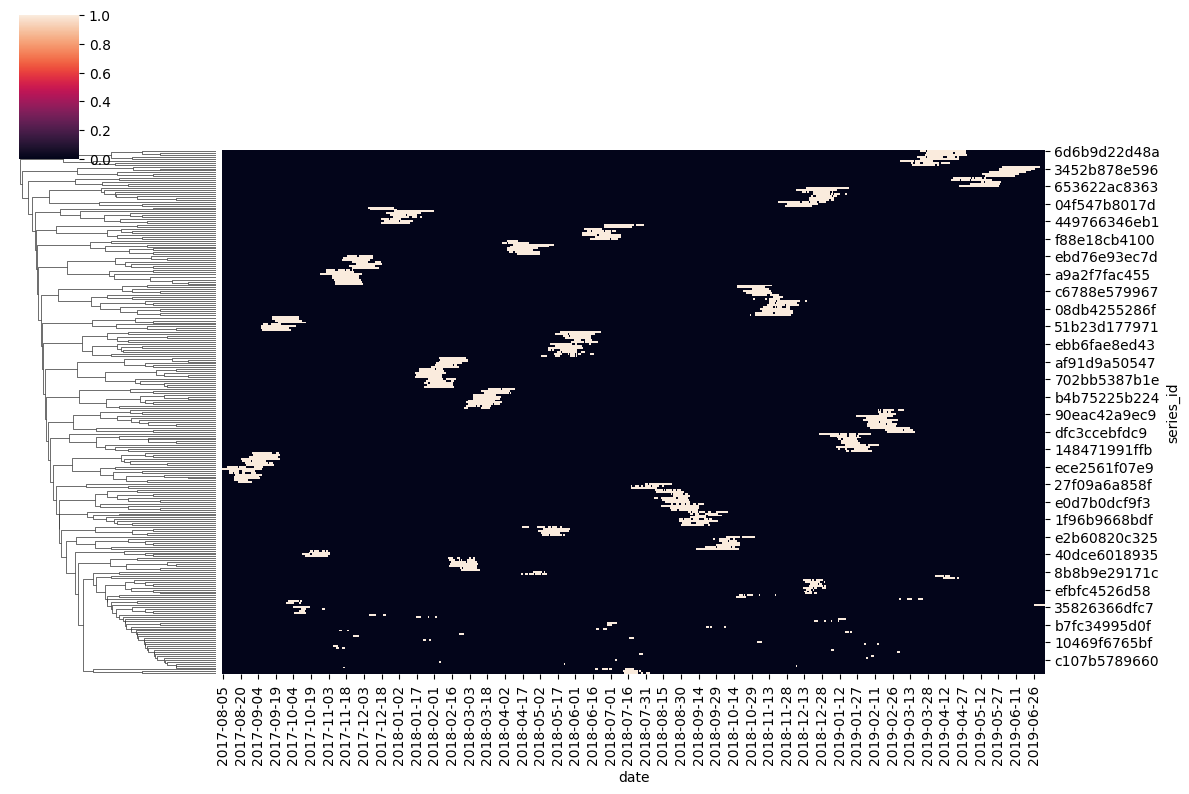

In [20]:
new_train_events = train_events.copy()

df_pivot = new_train_events.pivot_table(columns='date', index='series_id', values='step', aggfunc='count')

df_pivot = (~df_pivot.isna()).fillna(0).astype(np.uint8)

sns.clustermap(df_pivot, col_cluster=False, figsize=(12, 8))

### Class distributions

In [21]:
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

fig = make_subplots(rows=1, cols=2, subplot_titles=('Hourly Dist of Onset', 'Hourly Dist of Wakeup'))
fig.add_trace(go.Histogram(x=df_onset['hour'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_wakeup['hour'].dropna(), nbinsx=24), row=1, col=2)

fig.update_layout(
    showlegend=False,
    width=600,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template='plotly_white',
    colorway=px.colors.qualitative.Prism
)
fig.update_annotations(font_size=12)
fig.update_traces(opacity=0.75)

#### Total duration of sleep

In [22]:
mask = (~train_events['step'].isnull()) & (~train_events['timestamp'].isnull())
train_events_nonull = train_events[mask]

In [23]:
sleep_dur_df = train_events_nonull.groupby([train_events_nonull['series_id'], train_events_nonull['night']])['timestamp'].agg(['min', 'max']).reset_index()
sleep_dur_df = sleep_dur_df.rename(columns={
    'min': 'onset',
    'max': 'wakeup'
})
sleep_dur_df['sleep_duration'] = ((sleep_dur_df['wakeup'] - sleep_dur_df['onset']).dt.seconds / 3600).round(0)

df_g = sleep_dur_df['sleep_duration'].value_counts().reset_index()
df_g.columns = ['sleep_duration', 'num_of_obs']
fig = px.bar(
    df_g,
    x='sleep_duration',
    y='num_of_obs',
    title='Sleep Dur per Series',
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.show()

#### Number of nights per series

In [24]:
night_df = train_events.groupby(['series_id'])['night'].max()

check = {
    'series_id': night_df.index,
    'number_of_nights': night_df
}

agg_data = pd.DataFrame(check)

fig = px.histogram(
    agg_data,
    x='number_of_nights',
    marginal='rug',
    title='Dist of nights per series',
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig.show()


#### Proportion of data if Null Series removed

In [41]:
complete_series = series_by_id[~series_by_id].index.tolist()

In [51]:
train_events_filtered = train_events[train_events['series_id'].isin(complete_series)]

In [55]:
train_events_filtered.reset_index(drop=True)

,series_id,night,event,step,timestamp,date,time,hour
0,08db4255286f,1,onset,11988.0,2018-11-06 02:39:00,2018-11-06,02:39:00,2.0
1,08db4255286f,1,wakeup,14388.0,2018-11-06 05:59:00,2018-11-06,05:59:00,5.0
2,08db4255286f,2,onset,28680.0,2018-11-07 01:50:00,2018-11-07,01:50:00,1.0
3,08db4255286f,2,wakeup,31320.0,2018-11-07 05:30:00,2018-11-07,05:30:00,5.0
4,08db4255286f,3,onset,44184.0,2018-11-07 23:22:00,2018-11-07,23:22:00,23.0
...,...,...,...,...,...,...,...,...
1557,d5e47b94477e,21,wakeup,356172.0,2017-11-30 08:41:00,2017-11-30,08:41:00,8.0
1558,d5e47b94477e,22,onset,366756.0,2017-11-30 23:23:00,2017-11-30,23:23:00,23.0
1559,d5e47b94477e,22,wakeup,373176.0,2017-12-01 08:18:00,2017-12-01,08:18:00,8.0
1560,d5e47b94477e,23,onset,383616.0,2017-12-01 22:48:00,2017-12-01,22:48:00,22.0


## Train Series EDA

### Duplicated/Null values

### Distribution plot - enmo

### Distribution plot - anglez

### Additional Features

In [11]:
series_chunk = clean_df(series_chunk)
train_events = clean_df(train_events)

c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\Utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['timestamp'].str.split('T', expand=True)[0]
c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\Utils.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
c:\Users\amoha\Detect-Sleep-States-CMI\notebooks\Utils.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [12]:
print(train_events.memory_usage(deep=True).sum() / (1024 * 1024))
print(train_events.memory_usage(deep=True))
print('--------------------------')
print(train_events.dtypes)

3.769376754760742
Index            128
series_id    1001052
night         116064
event         906750
step          116064
timestamp     116064
date          799731
time          780561
hour          116064
dtype: int64
--------------------------
series_id            object
night                 int64
event                object
step                float64
timestamp    datetime64[ns]
date                 object
time                 object
hour                float64
dtype: object


In [13]:
new_train_events = train_events.copy()

# train_id_map = pd.DataFrame({
#     "series_id": new_train_events.series_id.unique(),
#     "id_map": list(new_train_events.series_id.unique()).index
# })
# # train_id_map.id_map = train_id_map.id_map.astype(np.uint16)
# train_id_map.to_parquet("../data/train_id_map.parquet", index=False)

new_train_events.night = new_train_events.night.astype(np.uint16)
new_train_events.event = new_train_events.event.replace({'onset':'0', 'wakeup':'1'}).astype(np.uint8)
# new_train_events.step = new_train_events.step.astype(np.uint32)

In [14]:
# new_train_events = new_train_events.merge(train_id_map, on='series_id', how='left')
# new_train_events = new_train_events.drop(columns=['series_id'])
# new_train_events = new_train_events.rename(columns={'id_map': 'series_id'})
new_train_events = transform_and_rename_dataframe(new_train_events, train_id_map, 'series_id', ['series_id'], {'id_map': 'series_id'})


In [15]:
print(train_events.memory_usage(deep=True).sum() / (1024 * 1024))
print(train_events.memory_usage(deep=True))
print('--------------------------')
print(train_events.dtypes)

3.769376754760742
Index            128
series_id    1001052
night         116064
event         906750
step          116064
timestamp     116064
date          799731
time          780561
hour          116064
dtype: int64
--------------------------
series_id            object
night                 int64
event                object
step                float64
timestamp    datetime64[ns]
date                 object
time                 object
hour                float64
dtype: object


In [16]:
print(new_train_events.memory_usage(deep=True).sum() / (1024 * 1024))
print(new_train_events.memory_usage(deep=True))
print('--------------------------')
print(new_train_events.dtypes)

2.019012451171875
Index        116064
night         29016
event         14508
step         116064
timestamp    116064
date         799731
time         780561
hour         116064
series_id     29016
dtype: int64
--------------------------
night                uint16
event                 uint8
step                float64
timestamp    datetime64[ns]
date                 object
time                 object
hour                float64
series_id            uint16
dtype: object


In [123]:
train = pd.merge(series_chunk, new_train_events[["step", "event"]], on="step", how="left")

In [141]:
train.event = train.event.bfill(axis = "rows")
train.event = train.event.fillna(1)
train.event = train.event.astype(np.uint8)

In [143]:
train

,step,timestamp,anglez,enmo,series_id,date,time,hour,event
0,0,2018-08-14 15:30:00,2.636700,0.0217,0,2018-08-14,15:30:00,15,0
1,1,2018-08-14 15:30:05,2.636800,0.0215,0,2018-08-14,15:30:05,15,0
2,2,2018-08-14 15:30:10,2.637000,0.0216,0,2018-08-14,15:30:10,15,0
3,3,2018-08-14 15:30:15,2.636800,0.0213,0,2018-08-14,15:30:15,15,0
4,4,2018-08-14 15:30:20,2.636800,0.0215,0,2018-08-14,15:30:20,15,0
...,...,...,...,...,...,...,...,...,...
100659,99995,2018-08-20 10:22:55,47.771099,0.0057,0,2018-08-20,10:22:55,10,1
100660,99996,2018-08-20 10:23:00,48.725399,0.0003,0,2018-08-20,10:23:00,10,1
100661,99997,2018-08-20 10:23:05,48.909401,0.0000,0,2018-08-20,10:23:05,10,1
100662,99998,2018-08-20 10:23:10,48.777802,0.0001,0,2018-08-20,10:23:10,10,1


In [137]:
train_events.groupby("series_id").tail(1)["event"].unique()

array(['wakeup'], dtype=object)